In [50]:
#Functions
def weighStats(row, dayWeight, locWeight):
    weight = 1 
    if row['DayNum'] > (132 * 0.75):
        weight += dayWeight
    if (row['WLoc'] == "A") or (row['WLoc'] == "N"):
        weight += locWeight
    # print(row)
    
    # Weighting winner stats
    row['Wsos'] = row['Wsos'] * weight
    row['Wposs'] = row['Wposs'] * weight
    row['Wshoot_eff'] = row['Wshoot_eff'] * weight 
    row['Wscore_op'] = row['Wscore_op'] * weight 
    row['Woff_rtg'] = row['Woff_rtg'] * weight 
    row['Wdef_rtg'] = row['Wdef_rtg'] * weight 
    row['Wts_pct'] = row['Wts_pct'] * weight 
    row['Wefg_pct'] = row['Wefg_pct'] * weight 
    row['Worb_pct'] = row['Worb_pct'] * weight 
    row['Wdrb_pct'] = row['Wdrb_pct'] * weight 
    row['Wreb_pct'] = row['Wreb_pct'] * weight 
    row['Wto_poss'] = row['Wto_poss'] * weight 
    row['Wft_rate'] = row['Wft_rate'] * weight 
    row['Wast_rtio'] = row['Wast_rtio'] * weight
    row['Wblk_pct'] = row['Wblk_pct'] * weight
    row['Wstl_pct'] = row['Wstl_pct'] * weight
    
    # Weighting Losses
#     row['Lposs'] = row['Lposs'] * weight
#     row['Lshoot_eff'] = row['Lshoot_eff'] * weight
#     row['Lscore_op'] = row['Lscore_op'] * weight
#     row['Loff_rtg'] = row['Loff_rtg'] * weight
#     row['Ldef_rtg'] = row['Ldef_rtg'] * weight
#     row['Lts_pct'] = row['Lts_pct'] * weight
#     row['Lefg_pct'] = row['Lefg_pct'] * weight
#     row['Lorb_pct'] = row['Lorb_pct'] * weight
#     row['Ldrb_pct'] = row['Ldrb_pct'] * weight
#     row['Lreb_pct'] = row['Lreb_pct'] * weight
#     row['Lto_poss'] = row['Lto_poss'] * weight
#     row['Lft_rate'] = row['Lft_rate'] * weight
#     row['Last_rtio'] = row['Last_rtio'] * weight
#     row['Lblk_pct'] = row['Lblk_pct'] * weight
#     row['Lstl_pct'] = row['Lstl_pct'] * weight

    return row


def calcAverages(df):
    df_avg = pd.DataFrame()

    df_avg['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
    df_avg['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

    df_avg['n_loss'].fillna(0, inplace=True)

    # Calculate win percentages:
    df_avg['win_pct'] = df_avg['n_wins'] / (df_avg['n_wins'] + df_avg['n_loss'])
    # Calculate averages for games won:
    df_avg['Wshoot_eff'] = df['Wshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wscore_op'] = df['Wscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Woff_rtg'] = df['Woff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wdef_rtg'] = df['Wdef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wsos'] = df['Wsos'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wts_pct'] = df['Wts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wefg_pct'] = df['Wefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Worb_pct'] = df['Worb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wdrb_pct'] = df['Wdrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wreb_pct'] = df['Wreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wto_poss'] = df['Wto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wft_rate'] = df['Wft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wie'] = df['Wie'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wast_rtio'] = df['Wast_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wblk_pct'] = df['Wblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wstl_pct'] = df['Wstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()

    # Calculate averages for games lost:
    df_avg['Lshoot_eff'] = df['Lshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lscore_op'] = df['Lscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Loff_rtg'] = df['Loff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Ldef_rtg'] = df['Ldef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lsos'] = df['Lsos'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lts_pct'] = df['Lts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lefg_pct'] = df['Lefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lorb_pct'] = df['Lorb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Ldrb_pct'] = df['Ldrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lreb_pct'] = df['Lreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lto_poss'] = df['Lto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lft_rate'] = df['Lft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lie'] = df['Lie'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Last_rtio'] = df['Last_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lblk_pct'] = df['Lblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lstl_pct'] = df['Lstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()

    return df_avg


def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

def predictMatches(clf, df_predict, df_features, year):
    diff = []
    data = []

    for i, row in df_predict.iterrows():
        year, team1, team2 = get_year_t1_t2(row.ID)
#         print("Year: {}; Team1: {}; Team2: {}".format(year, team1, team2))
#         Save 2018 stats/features for the first ID:
        team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

        # Save 2018 stats/features for the first ID:
        team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]   

        diff = team1 - team2

        data.append(diff)

    n_poss_games = len(df_predict)
    columns = df_features.columns.get_values()
#     print(columns)
    final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
    final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)
    print(final_predictions.columns)
    predictions = clf.predict_proba(final_predictions)[:, 1]
#     predLogLoss = log_loss(y_test, search.predict_proba(final_predictions))
    clipped_predictions = np.clip(predictions, 0.05, 0.95)
    df_predict.Pred = clipped_predictions
    
    return df_predict


# Source: https://www.kaggle.com/goodspellr/how-to-score-your-own-predictions-and-more
def kaggle_clip_log(x):
    '''
    Calculates the natural logarithm, but with the argument clipped within [1e-15, 1 - 1e-15]
    '''
    return np.log(np.clip(x,1.0e-15, 1.0 - 1.0e-15))

def kaggle_log_loss(pred, result):
    '''
    Calculates the kaggle log loss for prediction pred given result result
    '''
    return -(result*kaggle_clip_log(pred) + (1-result)*kaggle_clip_log(1.0 - pred))
    
def score_submission(df_sub, df_results, on_season=None, return_df_analysis=True):
    '''
    Scores a submission against relevant tournament results
    
    Parameters
    ==========
    df_sub: Pandas dataframe containing predictions to be scored (must contain a column called 'ID' and 
            a column called 'Pred')
            
    df_results: Pandas dataframe containing results to be compared against (must contain a column 
            called 'ID' and a column called 'Result')
            
    on_season: array-like or None.  If array, should contain the seasons for which a score should
            be calculated.  If None, will use all seasons present in df_results
            
    return_df_analysis: Bool.  If True, will return the dataframe used for calculations.  This is useful
            for future analysis
            
    Returns
    =======
    df_score: pandas dataframe containing the average score over predictions that were scorable per season
           as well as the number of obvious errors encountered
    df_analysis:  pandas dataframe containing information about all results used in scoring
                  Only provided if return_df_analysis=True
    '''
    
    df_analysis = df_results.copy()
    
    # this will overwrite if there's already a season column but it should be the same
    df_analysis['Season'] = [int(x.split('_')[0]) for x in df_results['ID']]
    
    if not on_season is None:
        df_analysis = df_analysis[np.in1d(df_analysis['Season'], on_season)]
        
    # left merge with the submission.  This will keep all games for which there
    # are results regardless of whether there is a prediction
    df_analysis = df_analysis.merge(df_sub, how='left', on='ID')
    
    # check to see if there are obvious errors in the predictions:
    # Obvious errors include predictions that are less than 0, greater than 1, or nan
    # You can add more if you like
    df_analysis['ObviousError'] = 1*((df_analysis['Pred'] < 0.0) \
                                  | (df_analysis['Pred'] > 1.0) \
                                  | (df_analysis['Pred'].isnull()))
    
    df_analysis['LogLoss'] = kaggle_log_loss(df_analysis['Pred'], df_analysis['Result'])
    
    df_score = df_analysis.groupby('Season').agg({'LogLoss' : 'mean', 'ObviousError': 'sum'})
    
    if return_df_analysis:
        return df_score, df_analysis
    else:
        return df_score
    
def convertTourneyRound(dayNum):
    """
    Consolidate tournament rounds into meaningful info.
    """
    if (dayNum == 136) | (dayNum == 137):
        return 64
    elif (dayNum == 138) | (dayNum == 139):
        return 32
    elif (dayNum == 143) | (dayNum == 144):
        return 16
    elif (dayNum == 145) | (dayNum == 146):
        return 8
    elif dayNum == 152:
        return 4
    elif dayNum == 154:
        return 2
    else:
        return 68
    
def processSeeds(df):
    df['seed'] = df_tourney_seeds['Seed'].apply(lambda x : int(x[1:3]))
    df.drop(columns={'Seed'}, inplace=True)
    return df

In [2]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import eli5
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from matplotlib.ticker import MaxNLocator
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
def buildModel(df_model, X, y, X_train, X_test, y_train, y_test, clf, grid):
    
    pipe = Pipeline([('clf', clf)])

    # Instantiate grid search using 10-fold cross validation:
    search = GridSearchCV(pipe, grid, cv=10, scoring='neg_log_loss')

    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)

    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)

    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

#     print('Best Parameters: {}'.format(search.best_params_))
#     print('Training Accuracy: {:0.2}'.format(train_accuracy))
#     print('Test Accuracy: {:0.2}'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])

    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))

#     print('logloss: {:0.7}'.format(logloss))
    returnParams = search.best_params_
    returnParams.update({'train_accuracy': train_accuracy})
    returnParams.update({'test_accuracy': test_accuracy})
    returnParams.update({'logloss': logloss})
    returnParams.update({'clf': clf})
    return returnParams
    # Plot all metrics in a grid of subplots:
#     fig = plt.figure(figsize=(12, 12))
#     grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)

    # Top-left plot - confusion matrix:
#     plt.subplot(grid[0, :2])
#     sns.heatmap(confusion_mtrx, annot=labels, fmt='')
#     plt.xlabel('Predicted Games')
#     plt.ylabel('Actual Games');

#     # Top-right plot - ROC curve:
#     plt.subplot(grid[0, 2:])
#     plt.plot([0, 1], [0, 1], linestyle='--')
#     plt.plot(fpr, tpr, marker='.')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('AUROC: {:0.3}'.format(auc));

#     # Bottom-left plot - support, or true predictions:
#     plt.subplot(grid[1, :2])
#     sns.countplot(y=predicted, orient='h')
#     plt.yticks([1, 0], ('wins', 'losses'))
#     plt.ylabel(''), plt.xlabel('Number Predicted');

    # Bottom-right plot - classification report:
    # plt.subplot(grid[1, 2:])
    # visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    # visualizer.fit(X_train, y_train)
    # visualizer.score(X_test, y_test)
    # g = visualizer.poof();


In [4]:
def buildModelDf(df_regularSeason_avgs, df_tourney_all, df_tourney_seeds):
    df_features = df_regularSeason_avgs[['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct']]
    # df_features.head() 
    df_features.dropna(inplace=True)
    
    # Merge seed data into Regular Season data
    df_features = pd.merge(df_tourney_seeds, df_features, how='outer', left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'])
    df_tourney = df_tourney_all[(df_tourney_all.Season >= 2003) & (df_tourney_all.Season < 2019)]
    df_tourney.reset_index(inplace=True, drop=True)

    # Merge tournament winners season features:
    df_winners = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
    df_winners.drop(['TeamID'], inplace=True, axis=1) 

    # Merge tournament games with features from losing team:
    df_losers = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
    df_losers.drop(['TeamID'], inplace=True, axis=1)

    # Creating a dataframe for the winning teams and assigning 1 to the result column to indiciate the win.
    df_winner_diff = (df_winners.iloc[:, 3:] - df_losers.iloc[:, 3:])
    df_winner_diff['result'] = 1

    # Creating a dataframe for the losing teams and assigning 0 to the result column to indiciate the loss.
    df_loser_diff = (df_losers.iloc[:, 3:] - df_winners.iloc[:, 3:])
    df_loser_diff['result'] = 0

    # Combine winning team data with losing team data
    df_model = pd.concat((df_winner_diff, df_loser_diff), axis=0)
    df_model.dropna(inplace=True)
#     if seed:
#         pass
#     else:
#         df_model.drop(columns={'seed'}, inplace=True)
        
    return df_model

###### Column names
* WFGM - field goals made (by the winning team)
* WFGA - field goals attempted (by the winning team)
* WFGM3 - three pointers made (by the winning team)
* WFGA3 - three pointers attempted (by the winning team)
* WFTM - free throws made (by the winning team)
* WFTA - free throws attempted (by the winning team)
* WOR - offensive rebounds (pulled by the winning team)
* WDR - defensive rebounds (pulled by the winning team)
* WAst - assists (by the winning team)
* WTO - turnovers committed (by the winning team)
* WStl - steals (accomplished by the winning team)
* WBlk - blocks (accomplished by the winning team)
* WPF - personal fouls committed (by the winning team)

In [5]:
stage2DataPath = 'data/Stage2DataFiles/'
dataPath = 'data/'

In [6]:

# Read in detail tournment results from 2018 and previous
df_tourneyDetailedResults = pd.read_csv(stage2DataPath + "NCAATourneyDetailedResults.csv")
# Read in the team names and teamID
df_regularSeason_teams = pd.read_csv(stage2DataPath + "Teams.csv")
# Read in the regular season results
df_regularSeason = pd.read_csv(stage2DataPath + "RegularSeasonDetailedResults.csv")
# Read in the Tournment seed data
df_tourney_seeds = pd.read_csv(stage2DataPath + "NCAATourneySeeds.csv")
# Read in Conference information
df_team_conf = pd.read_csv(stage2DataPath + 'TeamConferences.csv')
df_conf = pd.read_csv(stage2DataPath + "Conferences.csv")
df_tourneyCompact = pd.read_csv(stage2DataPath + "NCAATourneyCompactResults.csv")

In [7]:
df_tourney_seeds = processSeeds(df_tourney_seeds)

In [8]:
# df_regularSeason.head()

In [9]:
def buildRegularSeason(df_regularSeason, df_conf, df_team_conf):
    #     Merge team conference with conference
    df_regularSeason_conf_name = df_team_conf.merge(df_conf, on=['ConfAbbrev'])

    # Matching up winning and losing teamIDs
    win_teams = df_regularSeason_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
    win_confs = df_regularSeason_conf_name.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
    lose_teams = df_regularSeason_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
    lose_confs = df_regularSeason_conf_name.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

    # Merge conference and team name of winning team and losing team
    df_regularSeason = df_regularSeason.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
    .merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
    .merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
    .merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

    # Build two point Field goal information.
    # Providing data includes 3 point shots in the field goal data, so FG - FG3 will get the two point field goal data.
    df_regularSeason['WFGM2'] = df_regularSeason.WFGM - df_regularSeason.WFGM3
    df_regularSeason['WFGA2'] = df_regularSeason.WFGA - df_regularSeason.WFGA3
    df_regularSeason['LFGM2'] = df_regularSeason.LFGM - df_regularSeason.LFGM3
    df_regularSeason['LFGA2'] = df_regularSeason.LFGA - df_regularSeason.LFGA3

    # Winner stats related to offensive efficiency:
    df_regularSeason['Wposs'] = df_regularSeason.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
    df_regularSeason['Wshoot_eff'] = df_regularSeason.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
    df_regularSeason['Wscore_op'] = df_regularSeason.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
    df_regularSeason['Woff_rtg'] = df_regularSeason.apply(lambda row: row.WScore / row.Wposs*100, axis=1)

    # Loser stats related to offensive efficiency:
    df_regularSeason['Lposs'] = df_regularSeason.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
    df_regularSeason['Lshoot_eff'] = df_regularSeason.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
    df_regularSeason['Lscore_op'] = df_regularSeason.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
    df_regularSeason['Loff_rtg'] = df_regularSeason.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

    # Defensive and net efficiency:
    df_regularSeason['Wdef_rtg'] = df_regularSeason.apply(lambda row: row.Loff_rtg, axis=1)
    df_regularSeason['Wsos'] = df_regularSeason.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
    df_regularSeason['Ldef_rtg'] = df_regularSeason.apply(lambda row: row.Woff_rtg, axis=1)
    df_regularSeason['Lsos'] = df_regularSeason.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

    # Impact Estimate - 
    # First calculate the teams' overall statistical contribution (the numerator):
    Wie = df_regularSeason.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
    Lie = df_regularSeason.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

    # Then divide by the total game statistics (the denominator):
    df_regularSeason['Wie'] = Wie / (Wie + Lie) * 100
    df_regularSeason['Lie'] = Lie / (Lie + Wie) * 100

    # Other winner stats:
    df_regularSeason['Wts_pct'] = df_regularSeason.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
    df_regularSeason['Wefg_pct'] = df_regularSeason.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
    df_regularSeason['Worb_pct'] = df_regularSeason.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
    df_regularSeason['Wdrb_pct'] = df_regularSeason.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
    df_regularSeason['Wreb_pct'] = df_regularSeason.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
    df_regularSeason['Wto_poss'] = df_regularSeason.apply(lambda row: row.WTO / row.Wposs, axis=1)
    df_regularSeason['Wft_rate'] = df_regularSeason.apply(lambda row: row.WFTM / row.WFGA, axis=1)
    df_regularSeason['Wast_rtio'] = df_regularSeason.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
    df_regularSeason['Wblk_pct'] = df_regularSeason.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
    df_regularSeason['Wstl_pct'] = df_regularSeason.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)

    # Other loser stats:
    df_regularSeason['Lts_pct'] = df_regularSeason.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
    df_regularSeason['Lefg_pct'] = df_regularSeason.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
    df_regularSeason['Lorb_pct'] = df_regularSeason.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
    df_regularSeason['Ldrb_pct'] = df_regularSeason.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
    df_regularSeason['Lreb_pct'] = df_regularSeason.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
    df_regularSeason['Lto_poss'] = df_regularSeason.apply(lambda row: row.LTO / row.Lposs, axis=1)
    df_regularSeason['Lft_rate'] = df_regularSeason.apply(lambda row: row.LFTM / row.LFGA, axis=1)
    df_regularSeason['Last_rtio'] = df_regularSeason.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
    df_regularSeason['Lblk_pct'] = df_regularSeason.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
    df_regularSeason['Lstl_pct'] = df_regularSeason.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)
 
    return df_regularSeason, win_teams, win_confs, lose_teams, lose_confs


In [10]:
def buildTourneyCompact(df_tourneyCompact, df_tourney_seeds, win_teams, win_confs, lose_teams, lose_confs):
    df_tourneyCompact['tourn_round'] = df_tourneyCompact.DayNum.apply(convertTourneyRound)

#     df_tourney_seeds['seed'] = df_tourney_seeds['Seed'].apply(lambda x : int(x[1:3]))
#     df_tourney_seeds.head()

    # Drop Seed column
#     df_tourney_seeds.drop(columns={'Seed'}, inplace=True)

    # df_tourney_seeds.head()

    df_tourneyCompact = df_tourneyCompact.merge(df_tourney_seeds, how='left', 
                                                            left_on=['Season', 'WTeamID'], 
                                                            right_on=['Season', 'TeamID']) \
    .rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
    .merge(df_tourney_seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
    .rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
    .merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
    .merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
    .merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
    .merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

    # Calculate the point differential:
    df_tourneyCompact['point_diff'] = df_tourneyCompact.WScore - df_tourneyCompact.LScore
    return df_tourneyCompact

In [11]:
# def buildRegSeasonStats(df_regularSeason):
#     # Other winner stats:
#     df_regularSeason['Wts_pct'] = df_regularSeason.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
#     df_regularSeason['Wefg_pct'] = df_regularSeason.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
#     df_regularSeason['Worb_pct'] = df_regularSeason.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
#     df_regularSeason['Wdrb_pct'] = df_regularSeason.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
#     df_regularSeason['Wreb_pct'] = df_regularSeason.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
#     df_regularSeason['Wto_poss'] = df_regularSeason.apply(lambda row: row.WTO / row.Wposs, axis=1)
#     df_regularSeason['Wft_rate'] = df_regularSeason.apply(lambda row: row.WFTM / row.WFGA, axis=1)
#     df_regularSeason['Wast_rtio'] = df_regularSeason.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
#     df_regularSeason['Wblk_pct'] = df_regularSeason.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
#     df_regularSeason['Wstl_pct'] = df_regularSeason.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)

#     # Other loser stats:
#     df_regularSeason['Lts_pct'] = df_regularSeason.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
#     df_regularSeason['Lefg_pct'] = df_regularSeason.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
#     df_regularSeason['Lorb_pct'] = df_regularSeason.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
#     df_regularSeason['Ldrb_pct'] = df_regularSeason.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
#     df_regularSeason['Lreb_pct'] = df_regularSeason.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
#     df_regularSeason['Lto_poss'] = df_regularSeason.apply(lambda row: row.LTO / row.Lposs, axis=1)
#     df_regularSeason['Lft_rate'] = df_regularSeason.apply(lambda row: row.LFTM / row.LFGA, axis=1)
#     df_regularSeason['Last_rtio'] = df_regularSeason.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
#     df_regularSeason['Lblk_pct'] = df_regularSeason.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
#     df_regularSeason['Lstl_pct'] = df_regularSeason.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)
#     df_regularSeason.reset_index(inplace = True)
#     df_regularSeason = df_regularSeason.rename(columns={'Wshoot_eff':'shoot_eff', 'Wscore_op':'score_op', 
#                                     'Woff_rtg':'off_rtg', 'Wdef_rtg':'def_rtg', 'Wsos':'sos', 
#                                     'Wie':'ie', 'Wts_pct':'ts_pct', 'Wefg_pct':'efg_pct', 'Worb_pct':'orb_pct', 
#                                     'Wdrb_pct':'drb_pct', 'Wreb_pct':'reb_pct', 'Wto_poss':'to_poss', 
#                                     'Wft_rate':'ft_rate', 'Wast_rtio':'ast_rtio', 
#                                     'Wblk_pct':'blk_pct', 'Wstl_pct':'stl_pct'})
#     df_regularSeason = df_regularSeason.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
#     return df_regularSeason

In [12]:
### Feature Engineering

# Shooting Efficiency = Score / ( FGA + 0.475 * FTA )
# Scoring Opportunity = (FGA + 0.475 FTA)/(poss)
# Defensive Rating = opponent's offensive rating
# Offensive Rating = (score / poss) * 100
# Net Efficiency = offensive rating - opponent offensive rating

# Shooting features
# True Shooting percentage = ((score)/(2 * (FGA + 0.475 * FTA))) * 100
# Effective Field Goal Percentage = (FGM2 + 1.5 * FGM3) / (FGA)

# Rebounding features
# Offensive Rebound Percentage(orb_pct) = (OR) / (OR + opponent DR)
# Defensive Rebound Percentage(drb_pct) = (DR) / (DR + opponent OR)
# Rebound Percentage(reb_pct) = (orb_pct + drb_pct)/2

# Basketball on Paper author Dean Oliver outlines four factors that determine success in basketball:
# Effective Field Goal percentage
# Turnovers per possession(to_poss) = Turnovers / poss
# Offensive Rebound Percentage
# Free throw rate(ft_rate) = FTM / FGA

# https://stats.nba.com/help/faq/ - NBA Advanced Stats page
# Team Impact Estimate
# IE_numerator = Score + FGM + FTM - FGA - FTA + DR + 0.5 * OR + Ast + Stl + 0.5 * Blk - PF - TO
# IE = IE_numerator / (IE_Numerator + opp_IE_numerator)

# Assist Ratio(ast_rat) = (Ast / (FGA + 0.475 * FTA + TO + Ast)) * 100
# Block Percentage(blk_pct) = (Blk / opp_FGA2) * 100
# Steal Percentage(stl_pct) = (Stl / opp_poss) * 100

In [13]:
df_regularSeason, win_teams, win_confs, lose_teams, lose_confs = buildRegularSeason(df_regularSeason, df_conf, df_team_conf)

In [14]:
df_tourney_merge = buildTourneyCompact(df_tourneyCompact, df_tourney_seeds, win_teams, win_confs, lose_teams, lose_confs)    

In [15]:
df_tourney_all = df_tourney_merge[df_tourney_merge.Season < 2018]

In [16]:
# Dropping DayNum, WLoc, NumOT
# df_regularSeason.drop(columns={'DayNum', 'WLoc','NumOT'}, inplace=True)
df_regularSeason.drop(columns={'NumOT'}, inplace=True)

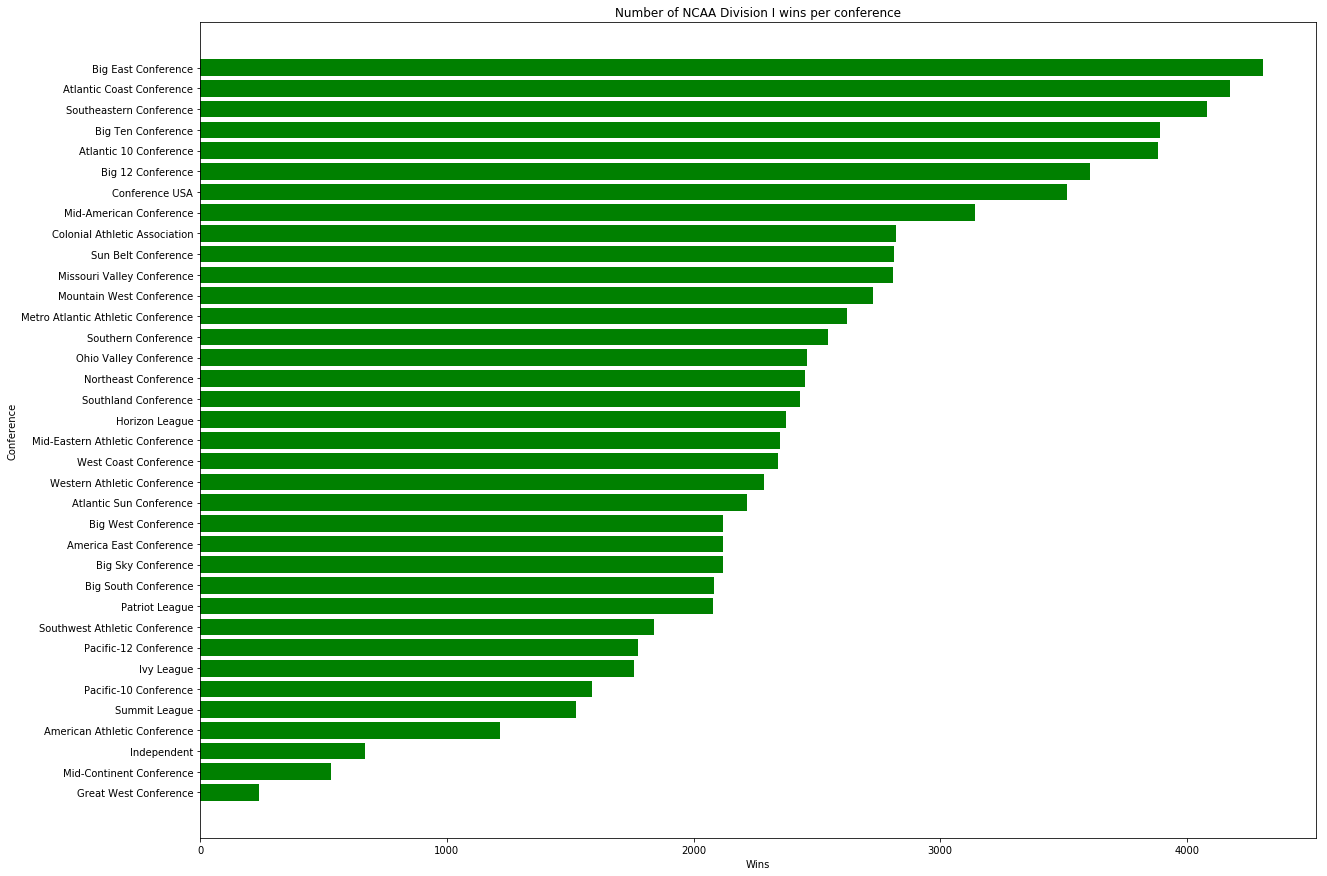

In [17]:
fig, ax = plt.subplots(figsize=(20,15))
y_bar = df_regularSeason["WConfName"].value_counts().tolist()
x_bar = df_regularSeason["WConfName"].value_counts().keys()
ax.barh(x_bar, y_bar, align='center',
        color='green', ecolor='black')
# ax.set_yticks(y_bar)
# ax.set_yticklabels(x_bar)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Wins')
ax.set_ylabel('Conference')
ax.set_title('Number of NCAA Division I wins per conference')

plt.show()

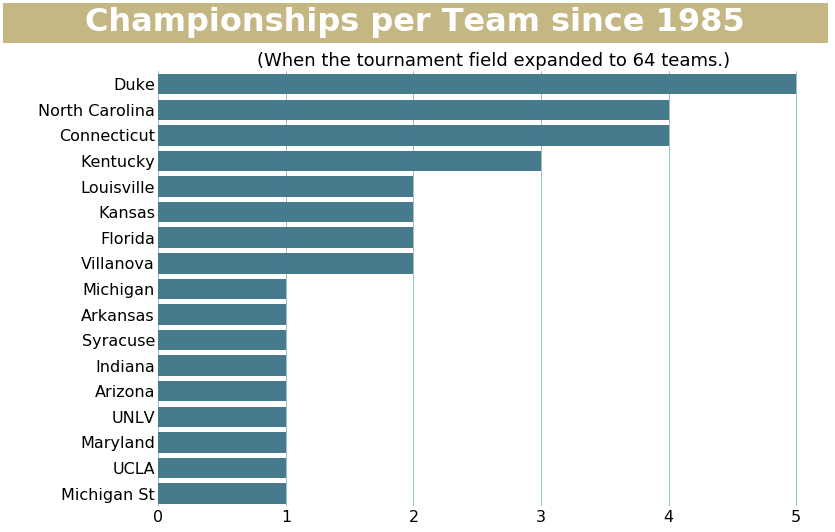

In [18]:
championships = df_tourney_all[df_tourney_all.tourn_round == 2]
# championships.columns
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=championships.WTeamName, order=championships.WTeamName.value_counts().index, color='#3c7f99')
plt.box(False)

fig.text(x=-0.05, y=0.95, s='       Championships per Team since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

In [19]:
df_graph = df_regularSeason.copy()
# df_graph.columns

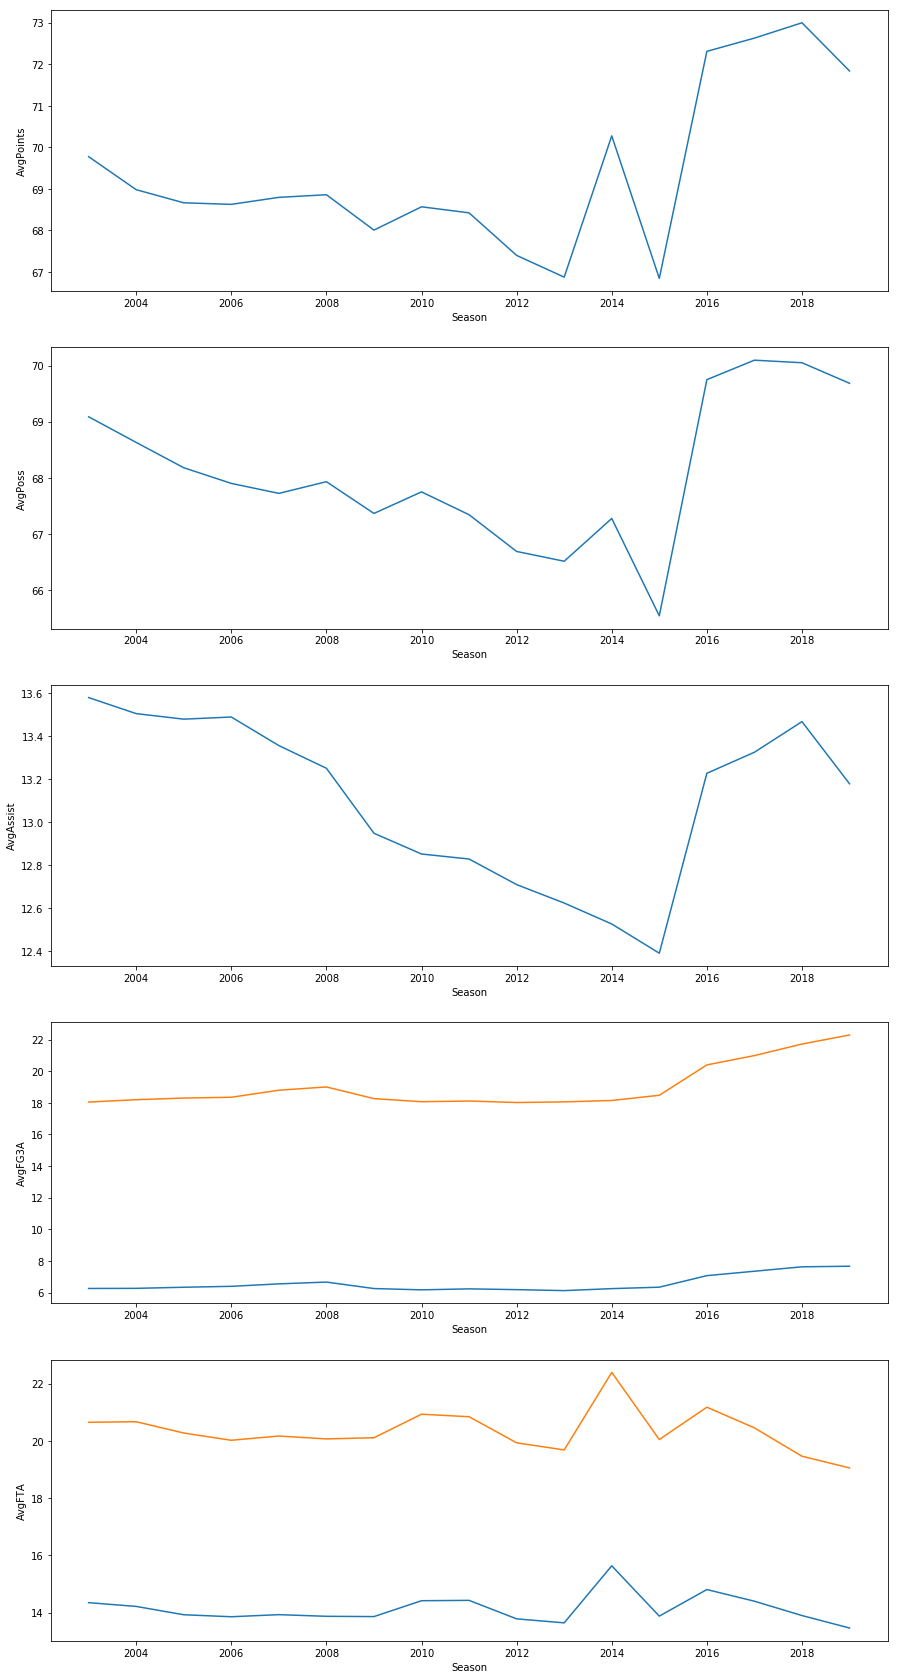

In [20]:
df_graph['AvgPoints'] = df_graph[['WScore','LScore']].mean(axis=1)
df_graph['AvgPoss'] = df_graph[['Wposs', 'Lposs']].mean(axis=1)
df_graph['AvgAssist'] = df_graph[['WAst', 'LAst']].mean(axis=1)
df_graph['AvgFG3A'] = df_graph[['WFGA3', 'LFGA3']].mean(axis=1)
df_graph['AvgFG3M'] = df_graph[['WFGM3', 'LFGM3']].mean(axis=1)
df_graph['AvgFTM'] = df_graph[['WFTM', 'LFTM']].mean(axis=1)
df_graph['AvgFTA'] = df_graph[['WFTA', 'LFTA']].mean(axis=1)
avgPoints = df_graph.groupby('Season').mean()
avgPoints = avgPoints.reset_index()

f, axes = plt.subplots(5, figsize=(15, 30))
sns.lineplot(x="Season", y="AvgPoints", data=avgPoints, ax=axes[0])
sns.lineplot(x="Season", y="AvgPoss", data=avgPoints, ax=axes[1])
sns.lineplot(x="Season", y="AvgAssist", data=avgPoints, ax=axes[2])
sns.lineplot(x="Season", y="AvgFG3M", data=avgPoints, ax=axes[3])
sns.lineplot(x="Season", y="AvgFG3A", data=avgPoints, ax=axes[3])
sns.lineplot(x="Season", y="AvgFTM", data=avgPoints, ax=axes[4])
sns.lineplot(x="Season", y="AvgFTA", data=avgPoints, ax=axes[4])

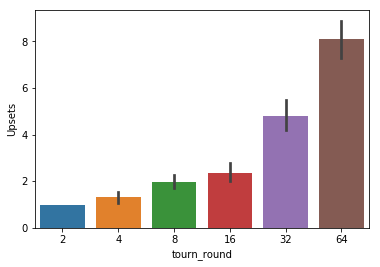

In [69]:
#Upsets per tourney round since 1985
df_upsets = df_tourney_all[(df_tourney_all.Wseed > df_tourney_all.Lseed) & (df_tourney_all.tourn_round <= 64)] \
    .groupby(['Season', 'tourn_round']).agg({'tourn_round':'count'}) \
    .rename(columns={"tourn_round":"Upsets"}) \
    .reset_index()
df_upsets

sns.barplot(x=df_upsets['tourn_round'], y=df_upsets['Upsets'])

In [22]:
from itertools import permutations 
# Weights from a broad search.
# weights = [x / 100.0 for x in range(0, 110, 10)]
# Results from a broad search to find the lowest logloss:
#  	Seed 	clf 	clf__C 	clf__penalty 	dayWeight 	execTime 	locWeight 	logloss 	test_accuracy 	train_accuracy
# 43 	True 	LogisticRegression(C=1.0, class_weight=None, d... 	0.0233 	l2 	0.2 	928 	0.3 	0.534233 	-0.534233 	-0.541868
# 41 	True 	LogisticRegression(C=1.0, class_weight=None, d... 	0.0233 	l2 	0.2 	720 	0.1 	0.534236 	-0.534236 	-0.541882

# Limiting search range to between 10 and 30 to see if there is a better logloss.
weights = [x / 100.0 for x in range(10, 30, 2)]
weightPerms = permutations(weights, 2)

In [24]:
seedStates = {True, False}
startLoopTime = time.time()
resultsList = []
for weight in weightPerms:
    start = time.time()
    tempDict = {}
    dayWeight,locWeight = weight
    
    df_regularSeason_weighted = df_regularSeason.apply(weighStats, axis=1, args=(dayWeight, locWeight),)

    df_regularSeason_weighted.reset_index(inplace = True)
    df_regularSeason_weighted.rename(columns={'Wshoot_eff':'shoot_eff', 'Wscore_op':'score_op', 
                                    'Woff_rtg':'off_rtg', 'Wdef_rtg':'def_rtg', 'Wsos':'sos', 
                                    'Wie':'ie', 'Wts_pct':'ts_pct', 'Wefg_pct':'efg_pct', 'Worb_pct':'orb_pct', 
                                    'Wdrb_pct':'drb_pct', 'Wreb_pct':'reb_pct', 'Wto_poss':'to_poss', 
                                    'Wft_rate':'ft_rate', 'Wast_rtio':'ast_rtio', 
                                    'Wblk_pct':'blk_pct', 'Wstl_pct':'stl_pct'}, inplace=True)
    df_regularSeason_weighted.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'}, inplace=True)
    df_model = buildModelDf(df_regularSeason_weighted, df_tourney_all, df_tourney_seeds)
    for seedState in seedStates:
        if seedState:
            ### With Seed
            # Select all columns except the results column 
            X = df_model.iloc[:, :-1]
        else:
            ### No Seed
            X = df_model.drop(columns={'seed'}).iloc[:, :-1]
        # Select the results column
        y = df_model.result

        # Split the dataframe into test and train of 25% test size.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=42)

        clf = LogisticRegression(random_state=42)
        grid = {'clf__C': np.logspace(start=-80, stop=40, num=50), 'clf__penalty': ['l1', 'l2'],}
        tempDict = buildModel(df_model, X, y, X_train, X_test, y_train, y_test, clf, grid)
        end = time.time()
        tempDict.update({"dayWeight":dayWeight, "locWeight":locWeight, "Seed":seedState,
                         "X_train": X_train, "X_test": X_test, "y_train": y_train, 
                         "y_test": y_test, "regSeason":df_regularSeason_weighted, 'execTime':int(end-start)})
        resultsList.append(tempDict)
        print("Exec Time: {} - dayWeight: {}, location Weight: {}, logloss: {}, SeedState: {}, Test Acc: {}, Train Acc: {}".format(int(end-start), tempDict['dayWeight'],tempDict['locWeight'],
                                                         tempDict['logloss'], seedState, tempDict['test_accuracy'],tempDict['train_accuracy']))

endLoopTime = time.time()

Exec Time: 386 - dayWeight: 0.1, location Weight: 0.12, logloss: 0.681663964220619, SeedState: False, Test Acc: -0.681663964220619, Train Acc: -0.6793004436558813
Exec Time: 624 - dayWeight: 0.1, location Weight: 0.12, logloss: 0.5410232755505703, SeedState: True, Test Acc: -0.5410232755505703, Train Acc: -0.5437220718092046
Exec Time: 402 - dayWeight: 0.1, location Weight: 0.14, logloss: 0.6816391099002141, SeedState: False, Test Acc: -0.6816391099002141, Train Acc: -0.6792907199196413
Exec Time: 651 - dayWeight: 0.1, location Weight: 0.14, logloss: 0.5410173806564925, SeedState: True, Test Acc: -0.5410173806564925, Train Acc: -0.5437157480236265
Exec Time: 422 - dayWeight: 0.1, location Weight: 0.16, logloss: 0.6816199909416419, SeedState: False, Test Acc: -0.6816199909416419, Train Acc: -0.6792931100309256
Exec Time: 670 - dayWeight: 0.1, location Weight: 0.16, logloss: 0.5409984671828301, SeedState: True, Test Acc: -0.5409984671828301, Train Acc: -0.5437128010439807
Exec Time: 399 

Exec Time: 509 - dayWeight: 0.14, location Weight: 0.26, logloss: 0.6816600121501912, SeedState: False, Test Acc: -0.6816600121501912, Train Acc: -0.6794644043066641
Exec Time: 839 - dayWeight: 0.14, location Weight: 0.26, logloss: 0.5410056597662536, SeedState: True, Test Acc: -0.5410056597662536, Train Acc: -0.5437168574955827
Exec Time: 507 - dayWeight: 0.14, location Weight: 0.28, logloss: 0.6816692683895225, SeedState: False, Test Acc: -0.6816692683895225, Train Acc: -0.6794805232460553
Exec Time: 835 - dayWeight: 0.14, location Weight: 0.28, logloss: 0.5409987615563568, SeedState: True, Test Acc: -0.5409987615563568, Train Acc: -0.5437172495968838
Exec Time: 421 - dayWeight: 0.16, location Weight: 0.1, logloss: 0.681797087556076, SeedState: False, Test Acc: -0.681797087556076, Train Acc: -0.6794568637268852
Exec Time: 670 - dayWeight: 0.16, location Weight: 0.1, logloss: 0.5410347324059802, SeedState: True, Test Acc: -0.5410347324059802, Train Acc: -0.5437619588483577
Exec Time: 

Exec Time: 484 - dayWeight: 0.2, location Weight: 0.22, logloss: 0.681747262703648, SeedState: False, Test Acc: -0.681747262703648, Train Acc: -0.6795888689249873
Exec Time: 817 - dayWeight: 0.2, location Weight: 0.22, logloss: 0.5410020227237401, SeedState: True, Test Acc: -0.5410020227237401, Train Acc: -0.5437518606851137
Exec Time: 520 - dayWeight: 0.2, location Weight: 0.24, logloss: 0.6817574056360709, SeedState: False, Test Acc: -0.6817574056360709, Train Acc: -0.6796089943853418
Exec Time: 844 - dayWeight: 0.2, location Weight: 0.24, logloss: 0.5410006213062017, SeedState: True, Test Acc: -0.5410006213062017, Train Acc: -0.5437482344246098
Exec Time: 536 - dayWeight: 0.2, location Weight: 0.26, logloss: 0.6817454116315813, SeedState: False, Test Acc: -0.6817454116315813, Train Acc: -0.67961450197045
Exec Time: 879 - dayWeight: 0.2, location Weight: 0.26, logloss: 0.5410106995318607, SeedState: True, Test Acc: -0.5410106995318607, Train Acc: -0.5437518891587869
Exec Time: 590 - 

Exec Time: 486 - dayWeight: 0.26, location Weight: 0.16, logloss: 0.6818327070556894, SeedState: False, Test Acc: -0.6818327070556894, Train Acc: -0.6797053631281375
Exec Time: 818 - dayWeight: 0.26, location Weight: 0.16, logloss: 0.5410037820709727, SeedState: True, Test Acc: -0.5410037820709727, Train Acc: -0.5437965184074244
Exec Time: 516 - dayWeight: 0.26, location Weight: 0.18, logloss: 0.6818274705623669, SeedState: False, Test Acc: -0.6818274705623669, Train Acc: -0.6797140951333633
Exec Time: 840 - dayWeight: 0.26, location Weight: 0.18, logloss: 0.5410006571501863, SeedState: True, Test Acc: -0.5410006571501863, Train Acc: -0.5437913788600047
Exec Time: 539 - dayWeight: 0.26, location Weight: 0.2, logloss: 0.6818197960343388, SeedState: False, Test Acc: -0.6818197960343388, Train Acc: -0.6797238555404956
Exec Time: 874 - dayWeight: 0.26, location Weight: 0.2, logloss: 0.5410003130039507, SeedState: True, Test Acc: -0.5410003130039507, Train Acc: -0.5437857197507505
Exec Time

In [25]:
# resultsList
# # print("Model Columns: {}".format(df_model.columns.values))
print("Processing time: {}".format(endLoopTime - startLoopTime))

Processing time: 71747.68806767464


In [26]:
clf_results = pd.DataFrame(resultsList)

In [27]:
# clf_results = pd.DataFrame(columns={"dayWeight", "locWeight", 'Seed'})
# df = clf_results.copy()
# weights = [x / 100.0 for x in range(0, 110, 10)]
# weightPerms = permutations(weights, 2)
# seedStates = {True, False}
# startLoopTime = time.time()
# tempList = []
# for weight in weightPerms:
#     start = time.time()
#     tempDict = {}
#     dayWeight,locWeight = weight
#     df_model = buildModelDf(df_regularSeason_weighted, df_tourney_all, df_tourney_seeds)
#     for seedState in seedStates:
# #         print
#         tempDict.update({"dayWeight":dayWeight, "locWeight":locWeight, "Seed":seedState})
#         print("{}".format(tempDict))
# #         df = df.append(tempDict, ignore_index=True)
#         tempList.append(tempDict)

# endLoopTime = time.time()

In [56]:
clf_results.sort_values(by=['logloss'], inplace=True, ascending=True)
clf_results.head(2)

,Seed,X_test,X_train,clf,clf__C,clf__penalty,dayWeight,execTime,locWeight,logloss,regSeason,test_accuracy,train_accuracy,y_test,y_train
175,True,seed shoot_eff score_op off_rtg ...,seed shoot_eff score_op off_rtg ...,"LogisticRegression(C=1.0, class_weight=None, d...",5.179475e+05,l2,0.28,923,0.22,0.540983,index Season DayNum TeamID WScore ...,-0.540983,-0.543797,1232 1 16095 1 13377 0 17619 0 16...,3773 0 9512 1 11541 0 20152 1 75...
179,True,seed shoot_eff score_op off_rtg ...,seed shoot_eff score_op off_rtg ...,"LogisticRegression(C=1.0, class_weight=None, d...",1.264855e+35,l2,0.28,964,0.26,0.540994,index Season DayNum TeamID WScore ...,-0.540994,-0.543786,1232 1 16095 1 13377 0 17619 0 16...,3773 0 9512 1 11541 0 20152 1 75...


In [58]:
# clf_results.iloc[0]
clf_results.columns

Index(['Seed', 'X_test', 'X_train', 'clf', 'clf__C', 'clf__penalty',
       'dayWeight', 'execTime', 'locWeight', 'logloss', 'regSeason',
       'test_accuracy', 'train_accuracy', 'y_test', 'y_train'],
      dtype='object')

In [30]:
# # Save the correlation matrix:
# matrix = df_regularSeason_avgs[['win_pct', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'ts_pct', 'efg_pct', 'orb_pct', 'drb_pct', 'reb_pct', 'to_poss', 'ft_rate', 'ast_rtio', 'blk_pct', 'stl_pct']].corr()

# fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
# # sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

# # Create mask for the upper triangle:
# mask = np.zeros_like(matrix, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Create a custom diverging colormap:
# cmap = sns.diverging_palette(225, 45, as_cmap=True)

# sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, annot=True, square=True, linewidths=0.25, cbar_kws={'shrink': 0.25}, ax=ax)
# plt.tick_params(axis='both', which='both',length=0)
# plt.tick_params(axis='both', which='major', labelsize=16)

# from scipy.stats.stats import pearsonr
# plt.title('Team Impact Estimate and Win Percentage correlate at an R square of {:0.3f}!'.format(pearsonr(df_regularSeason_avgs.ie, df_regularSeason_avgs.win_pct)[0]), fontsize=24, weight='bold')
# # fig.text(x=0.25, y=0.75, s='In fact, Win Percentage has a moderate or strong positive \nrelationship with most of the efficiency measures.', fontsize=20)

In [31]:
# NOTES 
# https://www.kaggle.com/humburgc/history-eda-machine-learning-march-madness

In [32]:
log_clf = LogisticRegression(random_state=42)
log_param_grid = {'clf__C': np.logspace(start=-80, stop=40, num=50), 'clf__penalty': ['l1', 'l2'],}
pipe = Pipeline([('clf', clf_results.iloc[0]['clf'])])
    
lr_search = GridSearchCV(pipe, log_param_grid, cv=10)
lr_search.fit(clf_results.iloc[0]['X_train'], clf_results.iloc[0]['y_train'])
print("Best C: {}; Best penalty: {}".format(lr_search.best_params_['clf__C'], lr_search.best_params_['clf__penalty']))

# perm = PermutationImportance(lr_search, random_state=42).fit(clf_results.iloc[0]['X_test'], clf_results.iloc[0]['y_test'])
# eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Best C: 0.023299518105153814; Best penalty: l1


In [70]:
# clf_results.iloc[0].regSeason.columns
# df_tourney_seeds

In [71]:
# clf_results.columns

In [34]:
df_predict_pre2019 = pd.read_csv(dataPath + 'SampleSubmissionStage1.csv')
df_predictions = pd.read_csv(dataPath + 'SampleSubmissionStage2.csv')
# df_predictions.head()

In [61]:

df_features = df_regularSeason[['Season', 'WTeamID', 'Wshoot_eff', 'Wscore_op', 'Woff_rtg', 
                                'Wdef_rtg', 'Wsos', 'Wie', 'Wefg_pct', 'Wto_poss', 'Worb_pct', 'Wft_rate', 
                                'Wreb_pct', 'Wdrb_pct', 'Wts_pct', 'Wast_rtio', 'Wblk_pct', 'Wstl_pct']]

df_features = df_features.merge(df_tourney_seeds.rename(columns={'Seed':'WSeed','TeamID':'WTeamID'}), 
                    how='inner', on=['Season', 'WTeamID'])

df_features = df_features.rename(columns={'Wshoot_eff':'shoot_eff', 'Wscore_op':'score_op', 
                                    'Woff_rtg':'off_rtg', 'Wdef_rtg':'def_rtg', 'Wsos':'sos', 
                                    'Wie':'ie', 'Wts_pct':'ts_pct', 'Wefg_pct':'efg_pct', 'Worb_pct':'orb_pct', 
                                    'Wdrb_pct':'drb_pct', 'Wreb_pct':'reb_pct', 'Wto_poss':'to_poss', 
                                    'Wft_rate':'ft_rate', 'Wast_rtio':'ast_rtio', 
                                    'Wblk_pct':'blk_pct', 'Wstl_pct':'stl_pct','WTeamID':'TeamID'})
df_features.columns


Index(['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg',
       'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct',
       'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', 'seed'],
      dtype='object')

In [62]:
year = 2019
predictMatches(lr_search, df_predictions, df_features, year).to_csv('best_model_results_{}.csv'.format(year), index=False)
# predictMatches(lr_search, df_predict_pre2019, df_features, year).to_csv('best_model_results_pre{}.csv'.format(year), index=False)

Index(['shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct',
       'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct',
       'ast_rtio', 'blk_pct', 'stl_pct', 'seed'],
      dtype='object')


In [64]:
from bracketeer import build_bracket

b = build_bracket(
        outputPath='best_bracket_{}.png'.format(year),
        submissionPath='best_model_results_2019.csv',
        teamsPath= stage2DataPath + 'Teams.csv',
        seedsPath= stage2DataPath + 'NCAATourneySeeds.csv',
        slotsPath= stage2DataPath + 'NCAATourneySlots.csv',
        year=year
)

In [65]:
## 2019 Predictions
from IPython.display import HTML, Image
import random
__counter__ = random.randint(0,2e9)

Image(url="best_bracket_2019.png")


In [66]:
# df_tourneyCompact
df_tc = pd.read_csv(stage2DataPath + "NCAATourneyCompactResults.csv")
df_tc['ID'] = df_tc['Season'].astype(str) + '_' \
              + (np.minimum(df_tc['WTeamID'],df_tc['LTeamID'])).astype(str) + '_' \
              + (np.maximum(df_tc['WTeamID'],df_tc['LTeamID'])).astype(str)

df_tc['Result'] = 1*(df_tc['WTeamID'] < df_tc['LTeamID'])
# df_tourneyCompact.head(10)

df_tc = df_tc.merge(df_tourney_seeds.rename(columns={'Seed':'WSeed','TeamID':'WTeamID'}), 
                    how='inner', on=['Season', 'WTeamID'])
df_tc = df_tc.merge(df_tourney_seeds.rename(columns={'Seed':'LSeed','TeamID':'LTeamID'}), 
                    how='inner', on=['Season', 'LTeamID'])
# Remove any play-in games
# df_playin = df_tc[df_tc['WSeed'].str[0:3] == df_tc['LSeed'].str[0:3]]
df_tc.head(10)
# df_tc = df_tc[df_tc['WSeed'].str[0:3] != df_tc['LSeed'].str[0:3]]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,Result,seed_x,seed_y
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1,9,8
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1,11,6
2,1985,138,1120,66,1242,64,N,0,1985_1120_1242,1,11,3
3,1985,136,1207,68,1250,43,N,0,1985_1207_1250,1,1,16
4,1985,138,1207,63,1396,46,N,0,1985_1207_1396,1,1,8
5,1985,143,1207,65,1260,53,N,0,1985_1207_1260,1,1,4
6,1985,145,1207,60,1210,54,N,0,1985_1207_1210,1,1,2
7,1985,152,1207,77,1385,59,N,0,1985_1207_1385,1,1,1
8,1985,136,1229,58,1425,55,N,0,1985_1229_1425,1,9,8
9,1985,136,1242,49,1325,38,N,0,1985_1242_1325,1,3,14


In [67]:
df_submission = pd.read_csv("best_model_results_pre2019.csv")
# df_submission.head()
df_score, df_analysis = score_submission(df_submission, df_tc, on_season = np.arange(2014,2019), return_df_analysis=True)
df_score

,LogLoss,ObviousError
Season,,
2014,0.594294,0
2015,0.504399,0
2016,0.576257,0
2017,0.513400,0
2018,0.600552,0


In [68]:
df_score['LogLoss'].mean()

0.5577806029527446